# **ENVIRONMENT**
- Link: https://drive.google.com/drive/folders/1Td29gdQ7dAzxvpqnqXv1W9e3Erob1uab?usp=sharing
- Structure:  
    - PROJ.ipynb (worksheet & this document)  
    - pictures (analysis pictures)  
    - datasets  
        - station_list.csv  
        - PRSA_Data_20130301-20170228 (what we used)  
        - beijing_20131205-20131231 (not used)  
        - ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive 
# Xiaohu Shen

/content/drive/MyDrive


In [ ]:
# change to your own path and make sure the datasets are included in the same folder
%cd /content/drive/MyDrive/ML/Project 
# Zihao Chu

/content/drive/MyDrive/ML/Project


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from random import shuffle

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **DATASETS**

In [ ]:
try:
    data_path0 = 'datasets'
    data_path1 = os.listdir(data_path0)
except:
    'folder datasets not found'

In [ ]:
# station dict for all datasets
try:
    stat_df = pd.read_csv(os.path.join(data_path0, 'station_list.csv'))
    stat_v = stat_df.values
    stat_dict = dict(zip(stat_v[:, 0], stat_v[:, 2:].astype(float)))
except:
    'file station_list.csv not found in list data_path1'

In [ ]:
# low pass filter with fs=0.8
lpfilt = np.array([-0.0315, 0.0213, 0, -0.0260, 0.0473,
                   -0.0541, 0.0390, 0, -0.0585, 0.1261,
                   -0.1892, 0.2339, 1, 0.2339, -0.1892,
                   0.1261, -0.0585, 0, 0.0390, -0.0541,
                   0.0473, -0.0260, 0, 0.0213, -0.0315])

## analysis (used for milestone)

max: 999, min: 2


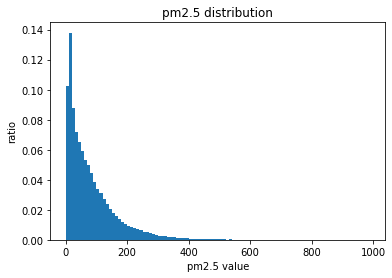

In [ ]:
data_path2 = os.listdir(os.path.join(data_path0, 'PRSA_Data_20130301-20170228'))
pm2d5 = []
for dataset_path in data_path2:
    dataset = pd.read_csv(os.path.join(data_path0, 'PRSA_Data_20130301-20170228', dataset_path))
    pm2d5.append(dataset['PM2.5'].fillna(method='ffill').values)

pm2d5 = np.hstack(pm2d5)
print('max: %d, min: %d' % (np.max(pm2d5), np.min(pm2d5)))

plt.figure()
weights = np.ones_like(pm2d5)/float(len(pm2d5))
plt.hist(pm2d5, weights=weights, bins=np.arange(0, 1000, 10))
plt.xlabel('pm2.5 value')
plt.ylabel('ratio')
plt.title('pm2.5 distribution')
plt.savefig('pictures/pm2d5_distribution.png')

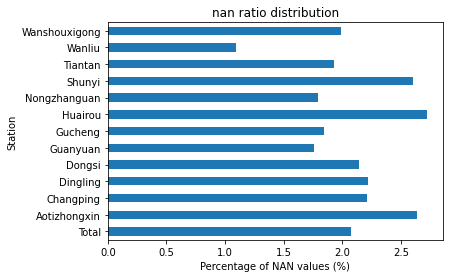

In [ ]:
data_path2 = os.listdir(os.path.join(data_path0, 'PRSA_Data_20130301-20170228'))
numNA_list = [] # nan ratio of each station
stat_list = [] # station name
for dataset_path in data_path2:
    dataset = pd.read_csv(os.path.join(data_path0, 'PRSA_Data_20130301-20170228', dataset_path))
    stat_list.append(dataset['station'][0]) 
    count_NA_sub = np.sum(pd.isna(dataset['PM2.5']))
    percent_sub = 100*count_NA_sub / dataset.shape[0]
    numNA_list.append(percent_sub)

stat_list.insert(0, 'Total')
numNA_list.insert(0, np.mean(numNA_list))
plt.figure()
pd.Series(data=numNA_list, index=stat_list).plot.barh()
plt.xlabel("Percentage of NAN values (%)")
plt.ylabel("Station")
plt.title('nan ratio distribution')
plt.savefig('pictures/pm2d5_nan_distribution.png')

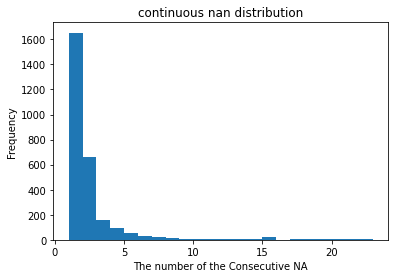

In [ ]:
data_path2 = os.listdir(os.path.join(data_path0, 'PRSA_Data_20130301-20170228'))
freq = []
for dataset_path in data_path2:
    dataset = pd.read_csv(os.path.join(data_path0, 'PRSA_Data_20130301-20170228', dataset_path))
    nan_list = pd.isna(dataset['PM2.5'])
    # calculate consecutive NA
    num_nan = 0
    for i in np.arange(len(nan_list)):
        if nan_list[i]:
            num_nan += 1
        elif num_nan:
            freq.append(num_nan)
            num_nan = 0

plt.figure()
plt.hist(freq, bins = np.arange(1, 24))
plt.ylabel("Frequency")
plt.xlabel("The number of the Consecutive NA")
plt.title('continuous nan distribution')
plt.savefig('pictures/pm2d5_continuous_nan_distribution.png')

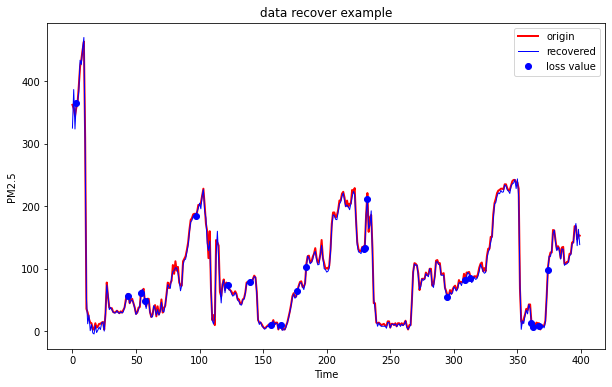

In [ ]:
dataset = pd.read_csv(os.path.join(data_path0, 'PRSA_Data_20130301-20170228', data_path2[0]))
x = dataset['PM2.5'][400:800]
num = len(x)
mask = np.random.rand(num)<0.95
x_loss = x * mask
x_reco = x.fillna(method='ffill')
x_reco = np.convolve(x_reco, lpfilt, 'same') * 0.8

loss_idx = [i for i in range(num) if mask[i]==False]
loss_val = [x_reco[i] for i in loss_idx]

plt.figure(figsize=[10, 6])
plt.plot(np.arange(num), x, color='red', linewidth=2, label='origin')
plt.plot(np.arange(num), x_reco, color='blue', linewidth=1, label='recovered')
plt.plot(loss_idx, loss_val, 'bo', label='loss value')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title('data recover example')
plt.legend()
plt.savefig('pictures/pm2d5_recover_example.png')

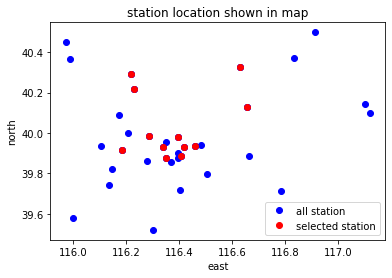

In [ ]:
all = list(stat_dict.values())
all_x = [all[i][0] for i in range(len(all))]
all_y = [all[i][1] for i in range(len(all))]
loc_x = [stat_dict[stat][0] for stat in stat_list if stat!='Total']
loc_y = [stat_dict[stat][1] for stat in stat_list if stat!='Total']

plt.figure()
plt.plot(all_x, all_y, 'bo', label='all station')
plt.plot(loc_x, loc_y, 'ro', label='selected station')
plt.xlabel('east')
plt.ylabel('north')
plt.title('station location shown in map')
plt.legend()
plt.savefig('pictures/station_location.png')

## ss1s6t (debug dataset)
- single value (pm2.5)
- short period (2013-2017)
- 1 stations
- 6 successive timestamps

input: $N\times6$ (no position info)  
output: $N\times1$

In [ ]:
try:
    data_path2 = os.listdir(os.path.join(data_path0, 'PRSA_Data_20130301-20170228'))
    dataset_path = data_path2[0] # Aotizhongxin
    dataset = pd.read_csv(os.path.join(data_path0, 'PRSA_Data_20130301-20170228', dataset_path))
    # fill nan value with previous value
    dataset['PM2.5'] = dataset['PM2.5'].fillna(method='ffill')
    # construct input data, 6 timestamps
    PM2D5 = dataset['PM2.5'].values
    ss1s6t_x = np.vstack([PM2D5[:-6], PM2D5[1:-5], PM2D5[2:-4], 
                          PM2D5[3:-3], PM2D5[4:-2], PM2D5[5:-1]]).transpose()
    # interpolation
    dataset['PM2.5'] = np.convolve(dataset['PM2.5'], lpfilt, 'same') * 0.8 # fs=0.8
    PM2D5 = dataset['PM2.5'].values
    ss1s6t_y = np.array(PM2D5[6:]).reshape(-1, 1)

except:
    'file PRSA_Data_Aotizhongxin_20130301-20170228.csv not found in list data_path1'


In [ ]:
ss1s6t_x.shape, ss1s6t_y.shape

((35058, 6), (35058, 1))

## ss12s12t (base dataset)

- single value (pm2.5)
- short period (2013-2017)
- 12 stations
- 12 successive timestamps

input: $N\times144$ (no position info)  
output: $N\times12$

In [ ]:
try:
    data_path2 = os.listdir(os.path.join(data_path0, 'PRSA_Data_20130301-20170228'))
    x_list, y_list = [], []
    for dataset_path in data_path2:
        dataset = pd.read_csv(os.path.join(data_path0, 'PRSA_Data_20130301-20170228', dataset_path))
        # fill nan value with previous value
        dataset['PM2.5'] = dataset['PM2.5'].fillna(method='ffill')
        # interpolation
        dataset['PM2.5'] = np.convolve(dataset['PM2.5'], lpfilt, 'same') * 0.8 # fs=0.8
        # construct input data, 12 timestamp
        PM2D5 = dataset['PM2.5'].values
        x_list.append(np.vstack([PM2D5[:-12], PM2D5[1:-11], PM2D5[2:-10], PM2D5[3:-9],
                                 PM2D5[4:-8], PM2D5[5:-7], PM2D5[6:-6], PM2D5[7:-5],
                                 PM2D5[8:-4], PM2D5[9:-3], PM2D5[10:-2], PM2D5[11:-1]]).transpose())
        y_list.append(PM2D5[12:])

    ss12s12t_x = np.hstack(x_list)
    ss12s12t_y = np.vstack(y_list).transpose()

except:
    'folder PRSA_Data_20130301-20170228.csv not found in list data_path1'

In [ ]:
ss12s12t_x.shape, ss12s12t_y.shape

((35052, 144), (35052, 12))

## ss12s6t

- single value (pm2.5)
- short period (2013-2017)
- 12 stations
- 6 successive timestamps

input: $N\times72$ (no position info)  
output: $N\times12$

In [ ]:
try:
    data_path2 = os.listdir(os.path.join(data_path0, 'PRSA_Data_20130301-20170228'))
    x_list, y_list = [], []
    for dataset_path in data_path2:
        dataset = pd.read_csv(os.path.join(data_path0, 'PRSA_Data_20130301-20170228', dataset_path))
        # fill nan value with previous value
        dataset['PM2.5'] = dataset['PM2.5'].fillna(method='ffill')
        # interpolation
        dataset['PM2.5'] = np.convolve(dataset['PM2.5'], lpfilt, 'same') * 0.8 # fs=0.8
        # construct input data, 12 timestamp
        PM2D5 = dataset['PM2.5'].values
        x_list.append(np.vstack([PM2D5[:-6], PM2D5[1:-5], PM2D5[2:-4], 
                                 PM2D5[3:-3], PM2D5[4:-2], PM2D5[5:-1]]).transpose())
        y_list.append(PM2D5[6:])

    ss12s6t_x = np.hstack(x_list)
    ss12s6t_y = np.vstack(y_list).transpose()

except:
    'folder PRSA_Data_20130301-20170228.csv not found in list data_path1'

In [ ]:
ss12s6t_x.shape, ss12s6t_y.shape

((35058, 72), (35058, 12))

## split dataset

In [ ]:
# Dataset params
BATCH_SIZE = 20 # batch size
TRAIN_RATIO = 0.6 # train dataset ratio
TEST_RATIO = 0.2 # test dataset ratio

In [ ]:
class AirDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def shuffle_two_lists(listA, listB):
    tmp = list(zip(listA, listB))
    shuffle(tmp)
    return zip(*tmp)


def generate_loader(x, y, shuffle=True):
    ''' return splited data loader '''
    # transfer data into float type
    x, y = x.astype('float32'), y.astype('float32')
    # calculate size of each part
    n = x.shape[0]
    train_size = int(n*TRAIN_RATIO)
    test_size = int(n*TEST_RATIO)
    val_size = n - train_size - test_size
    # shuffle data and split into three parts
    if shuffle:
        x, y = shuffle_two_lists(x, y)
    train_x, train_y = x[:train_size], y[:train_size]
    val_x, val_y = x[train_size:train_size+val_size], y[train_size:train_size+val_size]
    test_x, test_y = x[train_size+val_size:], y[train_size+val_size:]
    # generate loader
    train_loader = torch.utils.data.DataLoader(AirDataset(train_x, train_y),
                                               batch_size=BATCH_SIZE,
                                               shuffle=shuffle)
    val_loader   = torch.utils.data.DataLoader(AirDataset(val_x, val_y),
                                               batch_size = BATCH_SIZE,
                                               shuffle=shuffle)
    test_loader  = torch.utils.data.DataLoader(AirDataset(test_x, test_y),
                                               batch_size=BATCH_SIZE,
                                               shuffle=shuffle)
    return train_loader, val_loader, test_loader


## weights (not used)
$bins = [0,50,...,950]$

In [ ]:
data_path2 = os.listdir(os.path.join(data_path0, 'PRSA_Data_20130301-20170228'))
pm2d5 = []
for dataset_path in data_path2:
    dataset = pd.read_csv(os.path.join(data_path0, 'PRSA_Data_20130301-20170228', dataset_path))
    pm2d5.append(dataset['PM2.5'].fillna(method='ffill').values)

pm2d5 = np.hstack(pm2d5)
hist, bins = np.histogram(pm2d5, bins=20, range=(0, 1000), density=True)
loss_weights = 1 / hist
loss_weights = 20 * loss_weights / np.sum(loss_weights)

# **MODEL**

## MLP

In [ ]:
class MLP(nn.Module):
    ''' Multi-Layer Linear '''
    def __init__(self, in_feat, h_feat, out_feat):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_feat, h_feat)
        self.fc2 = nn.Linear(h_feat, h_feat)
        self.fc3 = nn.Linear(h_feat, out_feat)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        y = self.relu(self.fc1(x))
        y = self.relu(self.fc2(y))
        y = self.fc3(y)
        return y
    

## SAE+FC

In [ ]:
class AE(nn.Module):
    ''' Linear '''
    def __init__(self, in_feat, out_feat):
        super(AE, self).__init__()
        self.encoder = nn.Linear(in_feat, out_feat, bias=True)
        self.decoder = nn.Linear(out_feat, in_feat, bias=True)
        self.relu = nn.ReLU()
    
    def forward(self, x, train=False):
        y = self.encoder(x)
        y = self.relu(y)
        if train:
            return y, self.decoder(y)
        else:
            return y


class SAE(nn.Module):
    ''' AE->...->AE '''
    def __init__(self, feat_list):
        super(SAE, self).__init__()
        self.n_layer = len(feat_list)
        self.AE_list = [AE(feat_list[i][0], feat_list[i][1]) for i in range(self.n_layer)]

    def forward(self, x, train=False, train_layer=None):
        if train:
            for i in range(train_layer):
                x = self.AE_list[i](x)
            y, z = self.AE_list[train_layer](x, train=True)
            return x, y, z
        else:
            for i in range(self.n_layer):
                x = self.AE_list[i](x)
            return x


In [ ]:
class SAE3(nn.Module):
    ''' AE->AE->AE->FC '''
    def __init__(self, in_feat, out_feat, h_feat):
        super(SAE3, self).__init__()
        self.sae = SAE([(in_feat, h_feat),
                        (h_feat, h_feat),
                        (h_feat, h_feat)])
        self.out_layer = nn.Linear(h_feat, out_feat)

    def forward(self, x):
        y = self.sae(x)
        y = self.out_layer(y)
        return y


## RNN

In [ ]:
class RNN(nn.Module):
    ''' FC->RNN->FC '''
    def __init__(self, in_feat, out_feat, h_feat):
        super(RNN, self).__init__()
        self.fc1 = nn.Linear(in_feat, h_feat)
        self.relu = nn.ReLU()
        self.rnn = nn.RNN(h_feat, h_feat, num_layers=1, nonlinearity='relu')
        self.h0 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(1, 1, h_feat)))
        self.fc2 = nn.Linear(h_feat, out_feat)

    def forward(self, x):
        y = self.relu(self.fc1(x))
        h0 = torch.cat([self.h0]*x.shape[1], dim=1)
        _, y = self.rnn(y, h0)
        y = self.fc2(y[0])
        return y


# **TRAIN SETTINGS**

## loss

In [ ]:
def criterion_w(y_pred, y):
    ''' weighted loss '''
    mse_loss = F.mse_loss(y_pred, y, reduction='none')
    weights = torch.zeros(y_pred.shape).to(device)
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            weights = loss_weights[min(int(torch.floor(y_pred[i, j]/50)), 19)]
    return torch.sum(mse_loss * weights)

In [ ]:
def criterion(y_pred, y):
    ''' mse without weight '''
    return F.mse_loss(y_pred, y)

## train epoch

In [ ]:
def plot_loss(train_loss, val_loss, title):
    num_epoch = len(train_loss)
    plt.figure()
    plt.plot(np.arange(num_epoch)+1, train_loss, 'b', label='train loss')
    plt.plot(np.arange(num_epoch)+1, val_loss, 'r', label='val loss')
    plt.ylim([0, np.max(val_loss)*2])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title(title)


### MLP

In [ ]:
def trainMLP(model, train_loader, val_loader, show=False):
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, LR_DECAY)
    train_loss_list, val_loss_list = [], []
    # train dataset
    for epoch in tqdm(range(EPOCH)):
        train_loss, val_loss = [], []
        # train dataset
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y) # criterion_w
            loss.backward()
            optimizer.step()
            train_loss += [loss.item()]*x.shape[0]
        train_loss_list.append(np.mean(train_loss))
        # validation dataset
        model.eval()
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y) # criterion_w
            val_loss += [loss.item()]*x.shape[0]
        val_loss_list.append(np.mean(val_loss))
        # update learning rate
        scheduler.step()
    
    if show:
        plot_loss(train_loss_list, val_loss_list, 'MLP')
    
    return train_loss_list, val_loss_list
    

### SAE3

In [ ]:
def trainAE(model, train_layer, train_loader, val_loader, optimizer):
    model.train()
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, LR_DECAY)
    # lock parameters of previous AE
    for i in range(train_layer):
        for param in model.sae.AE_list[i].encoder.parameters():
            param.requires_grad = False
    # start training
    train_loss_list, val_loss_list = [], []
    for epoch in tqdm(range(AE_EPOCH)):
        train_loss, val_loss = [], []
        # train dataset
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            xAE, yAE, zAE = model.sae(x, train=True, train_layer=train_layer)
            loss = criterion(xAE, zAE)
            loss.backward()
            optimizer.step()
            train_loss += [loss.item()]*x.shape[0]
        train_loss_list.append(np.mean(train_loss))
        # validation dataset
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            xAE, yAE, zAE = model.sae(x, train=True, train_layer=train_layer)
            loss = criterion(xAE, zAE)
            val_loss += [loss.item()]*x.shape[0]
        val_loss_list.append(np.mean(val_loss))
        # update learning rate
        scheduler.step()
    
    return train_loss_list, val_loss_list


In [ ]:
def trainSAE3(model, train_loader, val_loader, show=False):
    model.train()
    # train AE layers sequentially and plot the train and val loss of each AE layer
    for train_layer in range(model.sae.n_layer):
        optimizer = optim.AdamW(model.sae.AE_list[train_layer].parameters(),
                                lr=AE_LR, weight_decay=WEIGHT_DECAY)
        train_loss, val_loss = trainAE(model, train_layer, train_loader, val_loader, optimizer)
        if show:
            plot_loss(train_loss, val_loss, 'AE layer %d' % train_layer)
    # unlock parameters of all AE
    for i in range(model.sae.n_layer):
        for param in model.sae.AE_list[i].encoder.parameters():
            param.requires_grad = True
    # train the output layer
    train_loss, val_loss = [], []
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, LR_DECAY)
    train_loss_list, val_loss_list = [], []
    for epoch in tqdm(range(EPOCH)):
        # train dataset
        train_loss, val_loss = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = F.mse_loss(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += [loss.item()]*x.shape[0]
        train_loss_list.append(np.mean(train_loss))
        # validation dataset
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = F.mse_loss(y_pred, y)
            val_loss += [loss.item()]*x.shape[0]
        val_loss_list.append(np.mean(val_loss))
        # update learning rate
        scheduler.step()
    
    if show:
        plot_loss(train_loss_list, val_loss_list, 'output layer')

    return train_loss_list, val_loss_list


### RNN

In [ ]:
def trainRNN(model, train_loader, val_loader, show=False):
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, LR_DECAY)
    train_loss_list, val_loss_list = [], []
    # train dataset
    for epoch in tqdm(range(EPOCH)):
        train_loss, val_loss = [], []
        # train dataset
        model.train()
        for x, y in train_loader:
            x = x.view(-1, 12, 12).permute(2, 0, 1)
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y) # criterion_w
            loss.backward()
            optimizer.step()
            train_loss += [loss.item()]*x.shape[0]
        train_loss_list.append(np.mean(train_loss))
        # validation dataset
        model.eval()
        for x, y in val_loader:
            x = x.view(-1, 12, 12).permute(2, 0, 1)
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y) # criterion_w
            val_loss += [loss.item()]*x.shape[0]
        val_loss_list.append(np.mean(val_loss))
        # update learning rate
        scheduler.step()
    
    if show:
        plot_loss(train_loss_list, val_loss_list, 'RNN')

    return train_loss_list, val_loss_list


## test epoch

In [ ]:
def test_all(model, test_loader, RNN=False):
    model.eval()
    test_loss = []
    for x, y in test_loader:
        n = x.shape[0]
        if RNN:
            x = x.view(-1, 12, 12).permute(2, 0, 1)
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y) # criterion_w
        test_loss += [loss.item()]*n
    
    return np.mean(test_loss)


In [ ]:
def test_some(model, x, y, time_range, RNN=False):
    ''' debug '''
    model.eval()
    x, y = x[time_range].astype('float32'), y[time_range].astype('float32')
    x, y = torch.Tensor(x).to(device), torch.Tensor(y).to(device)
    if RNN:
        x = x.view(-1, 12, 12).permute(2, 0, 1)
    y_pred = model(x)
    
    y_pred, y = y_pred.cpu().detach().numpy(), y.cpu().detach().numpy()
    for i in range(y.shape[1]):
        plt.figure(figsize=[5, 3])
        plt.plot(time_range, y[:, i], 'b', linewidth=2, label='ground truth')
        plt.plot(time_range, y_pred[:, i], 'r', linewidth=1, label='prediction')
        plt.xlabel('time index')
        plt.ylabel('PM2.5')
        plt.legend()
        plt.title('prediction at station %d' % i)


## MAPE

In [ ]:
def mape(model, test_loader, RNN=False):
    model.eval()
    test_mape = []
    for x, y in test_loader:
        n = x.shape[0]
        if RNN:
            x = x.view(-1, 12, 12).permute(2, 0, 1)
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        mean_mape = torch.mean(torch.min(torch.abs((y_pred-y)/y), torch.ones(y.shape).to(device))[0])
        test_mape += [mean_mape.item()]*n
    
    return np.mean(test_mape)


# **EXPERIMENT**

## DEBUG
model: MLP
- 3 fully connected layer $\rightarrow$ output layer
- $N\times6 \rightarrow N\times300 \rightarrow N\times300 \rightarrow N\times300 \rightarrow N\times1$

dataset: ss1s6t
- input: $N\times6$
- output: $N\times1$


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


test loss: 285.8017


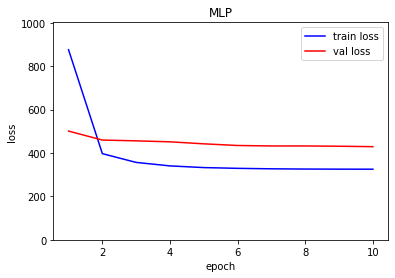

In [ ]:
# training params
EPOCH = 10 # train epoch for output layer
LR = 1e-2 # learning rate for whole model
LR_DECAY = 0.5 # learning rate decay coefficient after each epoch
WEIGHT_DECAY = 1e-3 # weight decay for regularization
# training
train_loader, val_loader, test_loader = generate_loader(ss1s6t_x, ss1s6t_y, shuffle=False)
model = MLP(in_feat=6, out_feat=1, h_feat=300)
model = model.to(device)
train_loss, val_loss = trainMLP(model, train_loader, val_loader, show=True)
test_loss = test_all(model, test_loader)
print("test loss: %4.4f" % (test_loss))

## MLP
model: MLP
- 3 fully connected layer $\rightarrow$ output layer
- $N\times144 \rightarrow N\times300 \rightarrow N\times300 \rightarrow N\times300 \rightarrow N\times12$

dataset: ss12s12t
- input: $N\times144$
- output: $N\times12$

In [ ]:
# training params
EPOCH = 10 # train epoch for output layer
LR = 1e-2 # learning rate for whole model
LR_DECAY = 0.5 # learning rate decay coefficient after each epoch
WEIGHT_DECAY = 1e-3 # weight decay for regularization
# training
n_repeat = 5
mape_list = []
test_loss_list = []
for i in range(n_repeat):
    train_loader, val_loader, test_loader = generate_loader(ss12s12t_x, ss12s12t_y, shuffle=True)
    model = MLP(in_feat=144, out_feat=12, h_feat=300)
    model = model.to(device)
    trainMLP(model, train_loader, val_loader)
    test_loss = test_all(model, test_loader)
    print("Repeat: %d, Loss: %4.4f, MAPE: %2.2f%%" % (i, test_loss, mape(model, test_loader)*100))
    mape_list += [mape(model, test_loader)]
    test_loss_list += [test_loss]

print("Avg Loss: %4.4f, Avg MAPE: %2.2f%%" % (np.mean(test_loss_list), np.mean(mape_list)*100))


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


Repeat: 0, Loss: 486.5923, MAPE: 24.44%


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


Repeat: 1, Loss: 407.3178, MAPE: 24.27%


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


Repeat: 2, Loss: 426.9896, MAPE: 23.92%


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


Repeat: 3, Loss: 439.4019, MAPE: 24.43%


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Repeat: 4, Loss: 595.5859, MAPE: 26.86%
Avg Loss: 471.1775, Avg MAPE: 25.03%


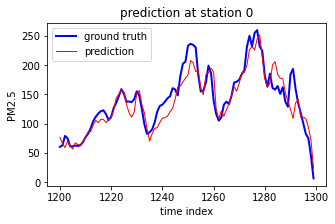

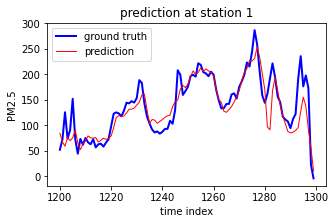

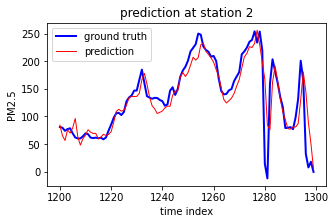

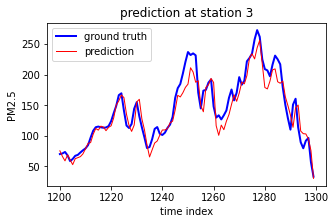

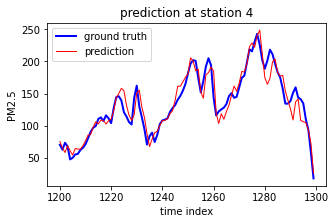

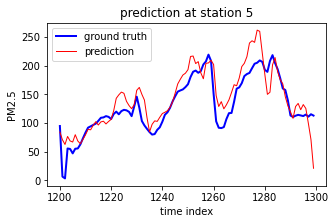

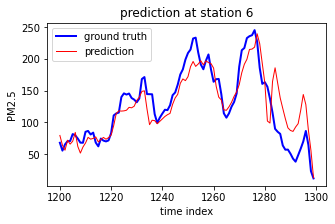

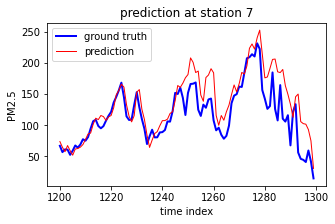

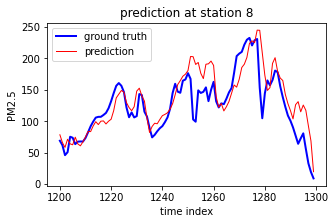

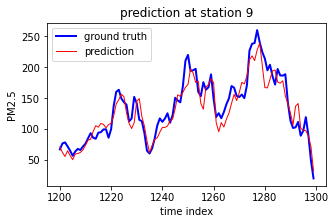

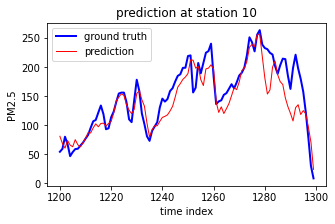

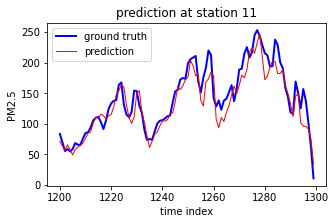

In [ ]:
# Prediction at each station
test_some(model, ss12s12t_x, ss12s12t_y, np.arange(1200, 1300))

## SAE3
model: SAE3
- 3 layer AutoEncoder $\rightarrow$ output layer
- $N\times144 \rightarrow N\times300 \rightarrow N\times300 \rightarrow N\times300 \rightarrow N\times12$

dataset: ss12s12t
- input: $N\times144$
- output: $N\times12$

In [ ]:
# training params
AE_EPOCH = 10 # train epoch for each AE
AE_LR = 1e-3 # learning rate for each AE
EPOCH = 10 # train epoch for output layer
LR = 1e-2 # learning rate for whole model
LR_DECAY = 0.5 # learning rate decay coefficient after each epoch
WEIGHT_DECAY = 1e-3 # weight decay for regularization
# training
n_repeat = 5
mape_list = []
test_loss_list = []
for i in range(n_repeat):
    train_loader, val_loader, test_loader = generate_loader(ss12s12t_x, ss12s12t_y, shuffle=True)
    model = SAE3(in_feat=144, out_feat=12, h_feat=300)
    model = model.to(device)
    for i in range(model.sae.n_layer):
        model.sae.AE_list[i].to(device)
    trainSAE3(model, train_loader, val_loader)
    test_loss = test_all(model, test_loader)
    print("Repeat: %d, Loss: %4.4f, MAPE: %2.2f%%" % (i, test_loss, mape(model, test_loader)*100))
    mape_list += [mape(model, test_loader)]
    test_loss_list += [test_loss]

print("Avg Loss: %4.4f, Avg MAPE: %2.2f%%" % (np.mean(test_loss_list), np.mean(mape_list)*100))

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Repeat: 2, Loss: 401.1487, MAPE: 24.06%


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Repeat: 2, Loss: 372.4893, MAPE: 25.06%


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


Repeat: 2, Loss: 387.4085, MAPE: 23.58%


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


Repeat: 2, Loss: 393.5108, MAPE: 24.15%


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Repeat: 2, Loss: 396.3845, MAPE: 24.85%
Avg Loss: 430.6829, Avg MAPE: 23.37%


## RNN
model: RNN
- 1 layer fully connect $\rightarrow$ output layer
- $N\times144 \rightarrow N\times300 \rightarrow N\times300 \rightarrow N\times300 \rightarrow N\times12$

dataset: ss12s12t
- input: $N\times144$
- output: $N\times12$

In [ ]:
# training params
EPOCH = 20 # train epoch for output layer
LR = 1e-2 # learning rate for whole model
LR_DECAY = 0.7 # learning rate decay coefficient after each epoch
WEIGHT_DECAY = 1e-3 # weight decay for regularization
# training
n_repeat = 5
mape_list = []
test_loss_list = []
for i in range(n_repeat):
    train_loader, val_loader, test_loader = generate_loader(ss12s12t_x, ss12s12t_y, shuffle=True)
    model = RNN(in_feat=12, out_feat=12, h_feat=300)
    model = model.to(device)
    trainRNN(model, train_loader, val_loader)
    test_loss = test_all(model, test_loader, RNN=True)
    print("Repeat: %d, Loss: %4.4f, MAPE: %2.2f%%" % (i, test_loss, mape(model, test_loader, RNN=True)*100))
    mape_list += [mape(model, test_loader, RNN=True)]
    test_loss_list += [test_loss]

print("Avg Loss: %4.4f, Avg MAPE: %2.2f%%" % (np.mean(test_loss_list), np.mean(mape_list)*100))

100%|██████████| 20/20 [01:05<00:00,  3.29s/it]


Repeat: 0, Loss: 210.6180, MAPE: 19.77%


100%|██████████| 20/20 [01:05<00:00,  3.30s/it]


Repeat: 1, Loss: 216.3685, MAPE: 19.73%


100%|██████████| 20/20 [01:06<00:00,  3.31s/it]


Repeat: 2, Loss: 237.6338, MAPE: 20.62%


100%|██████████| 20/20 [01:06<00:00,  3.30s/it]


Repeat: 3, Loss: 196.8632, MAPE: 19.17%


100%|██████████| 20/20 [01:06<00:00,  3.30s/it]


Repeat: 4, Loss: 206.8152, MAPE: 19.14%
Avg Loss: 213.6597, Avg MAPE: 20.35%


In [ ]:
# training params
EPOCH = 20 # train epoch for output layer
LR = 2e-4 # learning rate for whole model
LR_DECAY = 0.8 # learning rate decay coefficient after each epoch
WEIGHT_DECAY = 1e-3 # weight decay for regularization
# training
n_repeat = 5
mape_list = []
test_loss_list = []
for i in range(n_repeat):
    train_loader, val_loader, test_loader = generate_loader(ss12s12t_x, ss12s12t_y, shuffle=True)
    model = RNN(in_feat=12, out_feat=12, h_feat=300)
    model = model.to(device)
    trainRNN(model, train_loader, val_loader)
    test_loss = test_all(model, test_loader, RNN=True)
    print("Repeat: %d, Loss: %4.4f, MAPE: %2.2f%%" % (i, test_loss, mape(model, test_loader, RNN=True)*100))
    mape_list += [mape(model, test_loader, RNN=True)]
    test_loss_list += [test_loss]

print("Avg Loss: %4.4f, Avg MAPE: %2.2f%%" % (np.mean(test_loss_list), np.mean(mape_list)*100))

100%|██████████| 20/20 [01:30<00:00,  4.53s/it]


Repeat: 0, Loss: 157.0596, MAPE: 18.59%


100%|██████████| 20/20 [01:31<00:00,  4.55s/it]


Repeat: 1, Loss: 153.2434, MAPE: 16.06%


100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


Repeat: 2, Loss: 162.4485, MAPE: 16.45%


100%|██████████| 20/20 [01:31<00:00,  4.59s/it]


Repeat: 3, Loss: 158.0700, MAPE: 19.56%


100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


Repeat: 4, Loss: 162.5082, MAPE: 18.41%
Avg Loss: 158.6659, Avg MAPE: 18.02%


In [ ]:
# training params
EPOCH = 20 # train epoch for output layer
LR = 2e-4 # learning rate for whole model
LR_DECAY = 0.8 # learning rate decay coefficient after each epoch
WEIGHT_DECAY = 1e-2 # weight decay for regularization
# training
n_repeat = 5
mape_list = []
test_loss_list = []
for i in range(n_repeat):
    train_loader, val_loader, test_loader = generate_loader(ss12s12t_x, ss12s12t_y, shuffle=True)
    model = RNN(in_feat=12, out_feat=12, h_feat=300)
    model = model.to(device)
    trainRNN(model, train_loader, val_loader)
    test_loss = test_all(model, test_loader, RNN=True)
    print("Repeat: %d, Loss: %4.4f, MAPE: %2.2f%%" % (i, test_loss, mape(model, test_loader, RNN=True)*100))
    mape_list += [mape(model, test_loader, RNN=True)]
    test_loss_list += [test_loss]

print("Avg Loss: %4.4f, Avg MAPE: %2.2f%%" % (np.mean(test_loss_list), np.mean(mape_list)*100))

100%|██████████| 20/20 [01:29<00:00,  4.48s/it]


Repeat: 0, Loss: 165.1194, MAPE: 18.45%


100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


Repeat: 1, Loss: 173.1065, MAPE: 17.29%


100%|██████████| 20/20 [01:29<00:00,  4.46s/it]


Repeat: 2, Loss: 165.2864, MAPE: 17.11%


100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


Repeat: 3, Loss: 164.4285, MAPE: 16.92%


100%|██████████| 20/20 [01:29<00:00,  4.45s/it]


Repeat: 4, Loss: 154.3828, MAPE: 18.10%
Avg Loss: 164.4647, Avg MAPE: 18.03%


In [ ]:
# training params
EPOCH = 20 # train epoch for output layer
LR = 2e-4 # learning rate for whole model
LR_DECAY = 0.8 # learning rate decay coefficient after each epoch
WEIGHT_DECAY = 1e-1 # weight decay for regularization
# training
n_repeat = 5
mape_list = []
test_loss_list = []
for i in range(n_repeat):
    train_loader, val_loader, test_loader = generate_loader(ss12s12t_x, ss12s12t_y, shuffle=True)
    model = RNN(in_feat=12, out_feat=12, h_feat=300)
    model = model.to(device)
    trainRNN(model, train_loader, val_loader)
    test_loss = test_all(model, test_loader, RNN=True)
    print("Repeat: %d, Loss: %4.4f, MAPE: %2.2f%%" % (i, test_loss, mape(model, test_loader, RNN=True)*100))
    mape_list += [mape(model, test_loader, RNN=True)]
    test_loss_list += [test_loss]

print("Avg Loss: %4.4f, Avg MAPE: %2.2f%%" % (np.mean(test_loss_list), np.mean(mape_list)*100))

100%|██████████| 20/20 [01:31<00:00,  4.56s/it]


Repeat: 0, Loss: 153.8318, MAPE: 17.60%


100%|██████████| 20/20 [01:31<00:00,  4.55s/it]


Repeat: 1, Loss: 165.5217, MAPE: 17.90%


100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


Repeat: 2, Loss: 178.8416, MAPE: 18.56%


100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


Repeat: 3, Loss: 172.5489, MAPE: 17.87%


100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


Repeat: 4, Loss: 171.1541, MAPE: 17.38%
Avg Loss: 168.3796, Avg MAPE: 17.75%


In [ ]:
# it might be useful some day
# Set the tqdm text color to white.
from IPython.display import HTML, display
def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)